# Data cleaning

Vamos a empezar con un pequeño analisis inicial de los datos a mano, haciendo limpiezas y adecuaciones según nos parezca adecuado. 

Luego pasaremos a la parte de entrenamiento de modelos.


### Configuración espacio de trabajo

In [47]:
import pandas as pd
import numpy as np
from copy_repo_ML import *
from copy_repo_funciones import *
import matplotlib.pyplot as plt
import re
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split as tts
from lazypredict.Supervised import LazyRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import h2o
from h2o.automl import H2OAutoML

In [48]:
#%pip install lazypredict
#%pip install h2o

In [49]:
train=pd.read_csv('../DATA/train.csv')
test=pd.read_csv('../DATA/test.csv')

In [131]:
muestra=pd.read_csv('../DATA/muestra.csv')

In [51]:
precios= train.Price #Guardamos en esta variable la columna de precios de train. Esto porque vamos a concatenar train y test para homogenizar la limpieza y se agregará a posteriori
train.drop(columns='Price', inplace=True)

In [52]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 977 entries, 0 to 976
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Manufacturer              977 non-null    object
 1   Model Name                977 non-null    object
 2   Category                  977 non-null    object
 3   Screen Size               977 non-null    object
 4   Screen                    977 non-null    object
 5   CPU                       977 non-null    object
 6   RAM                       977 non-null    object
 7    Storage                  977 non-null    object
 8   GPU                       977 non-null    object
 9   Operating System          977 non-null    object
 10  Operating System Version  841 non-null    object
 11  Weight                    977 non-null    object
dtypes: object(12)
memory usage: 91.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 12 co

(None, None)

In [53]:
data=pd.concat([train,test])
data.reset_index(drop=True, inplace=True)

In [54]:
data.shape

(1302, 12)

## 1. Analisis inicial

Aquí buscamos familiarizarnos con los datos. Esto es un paso imprescindible para ML, ya que va a ser necesario optimizar los datos para el modelo.

Algunas de las incognitas que buscamos despejar a través de este analisis son:

 - Datos nulos y duplicados
    - Habrá que ver si eliminamos las filas con muchos datos nulos o los rellenamos con media, moda o mediana
 - Tipo de dato por columna 
    - cuales son numericos o no
    - cuales son categoricos. Estos los tendremos que transformar a formato numerico. 
      - Para los categoricos tambien va a haber que evaluar cuantos valores unicos hay por columna. 
      - En el caso de que sean muchos habrá que evaluar como agruparlos. De lo contario podria confundir al modelo. 
 - Correlacion/colinealidad entre columnas
 - Distribución de los datos: outliers y sesgo(skew)



In [55]:
data.info() # Vemos que hay datos nulos en la columna de Operating system version pero no muchos. En fase 2 de limpieza hay que plantearse que hacer con ellos. 
#Hechando un vistazo a los tipos de datos, podemos ver que todos son objetos menos precio. Lo que me hace ruido son algunas columnas que hubiese intuido serian de valor numerico como:
    # -Screen size
    #- CPU
    #- RAM
    # -STORAGE
    # - Weight
    #operating system version

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Manufacturer              1302 non-null   object
 1   Model Name                1302 non-null   object
 2   Category                  1302 non-null   object
 3   Screen Size               1302 non-null   object
 4   Screen                    1302 non-null   object
 5   CPU                       1302 non-null   object
 6   RAM                       1302 non-null   object
 7    Storage                  1302 non-null   object
 8   GPU                       1302 non-null   object
 9   Operating System          1302 non-null   object
 10  Operating System Version  1132 non-null   object
 11  Weight                    1302 non-null   object
dtypes: object(12)
memory usage: 122.2+ KB


In [56]:
data.head() #Hay que quita la comilla final de screen size, RAM quitarle el GB, Storage limpiar para dejar unicamente valor numerico, talvez col aparte para SSD/disco duro, weight quitar kg

,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Operating System Version,Weight
0,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,NaN,1.37kg
1,Apple,Macbook Air,Ultrabook,"13.3""",1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,NaN,1.34kg
2,HP,250 G6,Notebook,"15.6""",Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,NaN,1.86kg
3,Apple,MacBook Pro,Ultrabook,"15.4""",IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,NaN,1.83kg
4,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,NaN,1.37kg


In [57]:
unique_cols(data)

#Model Name tiene demasiados valores unicos como para ser representativo (candidato para la guillotina)
#Agrupar en rangos: Weight/Screen/Storage
#CPU/GPU investigar como limpiar y si es mu dificil guillotina
#

Model Name                  617
Weight                      179
CPU                         118
GPU                         110
Screen                       40
 Storage                     38
Manufacturer                 19
Screen Size                  18
RAM                           9
Operating System              7
Category                      6
Operating System Version      4
dtype: int64

In [58]:
data['Screen Size'].value_counts()

Screen Size
15.6"    664
14.0"    197
13.3"    164
17.3"    164
12.5"     39
11.6"     33
12.0"      6
13.5"      6
13.9"      6
12.3"      5
10.1"      4
15.4"      4
15.0"      4
13.0"      2
18.4"      1
17.0"      1
14.1"      1
11.3"      1
Name: count, dtype: int64

In [59]:
data['Category'].value_counts()

Category
Notebook              727
Gaming                205
Ultrabook             196
2 in 1 Convertible    120
Workstation            29
Netbook                25
Name: count, dtype: int64

In [60]:
data['Operating System Version'].value_counts() #Esta categoria no parece que nos vaya a aportar nada 

Operating System Version
10      1071
7         45
X          8
10 S       8
Name: count, dtype: int64

In [61]:
data['Operating System'].value_counts() # Por lo pronto Mac homogenizar. 

Operating System
Windows      1124
No OS          66
Linux          62
Chrome OS      27
macOS          13
Mac OS          8
Android         2
Name: count, dtype: int64

In [62]:
data['Screen'].value_counts()

Screen
Full HD 1920x1080                                507
1366x768                                         281
IPS Panel Full HD 1920x1080                      230
IPS Panel Full HD / Touchscreen 1920x1080         53
Full HD / Touchscreen 1920x1080                   47
1600x900                                          23
Touchscreen 1366x768                              16
Quad HD+ / Touchscreen 3200x1800                  15
IPS Panel 4K Ultra HD 3840x2160                   12
IPS Panel 4K Ultra HD / Touchscreen 3840x2160     11
4K Ultra HD / Touchscreen 3840x2160                9
4K Ultra HD 3840x2160                              7
Touchscreen 2560x1440                              7
IPS Panel 1366x768                                 7
IPS Panel Quad HD+ / Touchscreen 3200x1800         6
IPS Panel Retina Display 2560x1600                 6
IPS Panel Retina Display 2304x1440                 6
Touchscreen 2256x1504                              6
IPS Panel Touchscreen 2560x1440        

In [63]:
col_unique_counts(data, 'CPU')

,CPU,Count
0,Intel Core i5 7200U 2.5GHz,190
1,Intel Core i7 7700HQ 2.8GHz,146
2,Intel Core i7 7500U 2.7GHz,133
3,Intel Core i7 8550U 1.8GHz,73
4,Intel Core i5 8250U 1.6GHz,72
5,Intel Core i5 6200U 2.3GHz,68
6,Intel Core i3 6006U 2GHz,64
7,Intel Core i7 6500U 2.5GHz,49
8,Intel Core i7 6700HQ 2.6GHz,43
9,Intel Core i3 7100U 2.4GHz,37


In [64]:
data[' Storage'].value_counts()

 Storage
256GB SSD                        412
1TB HDD                          224
500GB HDD                        132
512GB SSD                        118
128GB SSD +  1TB HDD              94
128GB SSD                         76
256GB SSD +  1TB HDD              73
32GB Flash Storage                38
2TB HDD                           16
64GB Flash Storage                15
512GB SSD +  1TB HDD              14
1TB SSD                           14
256GB SSD +  2TB HDD              10
1TB Hybrid                         9
256GB Flash Storage                8
16GB Flash Storage                 7
32GB SSD                           6
1GB SSD                            5
128GB Flash Storage                4
16GB SSD                           3
512GB Flash Storage                2
1TB SSD +  1TB HDD                 2
512GB SSD +  2TB HDD               2
256GB SSD +  500GB HDD             2
128GB SSD +  2TB HDD               2
256GB SSD +  256GB SSD             2
512GB SSD +  256GB SSD       

In [65]:
col_unique_counts(data, 'GPU')

,GPU,Count
0,Intel HD Graphics 620,281
1,Intel HD Graphics 520,185
2,Intel UHD Graphics 620,68
3,Nvidia GeForce GTX 1050,66
4,Nvidia GeForce GTX 1060,48
5,Nvidia GeForce 940MX,43
6,AMD Radeon 530,41
7,Intel HD Graphics 500,39
8,Intel HD Graphics 400,37
9,Nvidia GeForce GTX 1070,30


In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Manufacturer              1302 non-null   object
 1   Model Name                1302 non-null   object
 2   Category                  1302 non-null   object
 3   Screen Size               1302 non-null   object
 4   Screen                    1302 non-null   object
 5   CPU                       1302 non-null   object
 6   RAM                       1302 non-null   object
 7    Storage                  1302 non-null   object
 8   GPU                       1302 non-null   object
 9   Operating System          1302 non-null   object
 10  Operating System Version  1132 non-null   object
 11  Weight                    1302 non-null   object
dtypes: object(12)
memory usage: 122.2+ KB


## 2. Limpieza

Tras realizar el analisis inicial, vamos a hacer adecuaciones a los datos para optimizar el archivo.


In [67]:
data.rename(columns={' Storage': 'Storage'}, inplace=True)
data['Screen Size']=data['Screen Size'].str.rstrip('"')
data['RAM']=data['RAM'].str.rstrip('GB')
data['Weight']=data['Weight'].str.rstrip('kg')
data = data.drop('Model Name', axis=1)
data = data.drop('Operating System Version', axis=1)
data.loc[data['Operating System']=='macOS', 'Operating System']='Mac OS' 
data['touchscreen'] = data['Screen'].str.contains('Touchscreen', case=False).astype(int)
data['Screen'] = data['Screen'].str.extract(r'(\d+x\d+)') #regex para quitar los valores no numericos y dejar unicamente la resolución es decir dos numeros entre una x.

In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Manufacturer      1302 non-null   object
 1   Category          1302 non-null   object
 2   Screen Size       1302 non-null   object
 3   Screen            1302 non-null   object
 4   CPU               1302 non-null   object
 5   RAM               1302 non-null   object
 6   Storage           1302 non-null   object
 7   GPU               1302 non-null   object
 8   Operating System  1302 non-null   object
 9   Weight            1302 non-null   object
 10  touchscreen       1302 non-null   int32 
dtypes: int32(1), object(10)
memory usage: 106.9+ KB


In [69]:
data.loc[data['Screen']=='1440x900', 'Screen']='HD'
data.loc[data['Screen']=='1366x768', 'Screen']='HD'
data.loc[data['Screen']=='1600x900', 'Screen']='HD'
data.loc[data['Screen']=='1920x1080', 'Screen']='HD'
data.loc[data['Screen']=='3200x1800', 'Screen']='QHD'
data.loc[data['Screen']=='2560x1440', 'Screen']='QHD'
data.loc[data['Screen']=='2560x1600', 'Screen']='QHD'
data.loc[data['Screen']=='2256x1504', 'Screen']='QHD'
data.loc[data['Screen']=='2880x1800', 'Screen']='QHD'
data.loc[data['Screen']=='2304x1440', 'Screen']='QHD'
data.loc[data['Screen']=='2400x1600', 'Screen']='QHD'
data.loc[data['Screen']=='3840x2160', 'Screen']='UHD'
data.loc[data['Screen']=='1920x1200', 'Screen']='HD'
data.loc[data['Screen']=='2160x1440', 'Screen']='QHD'
data.loc[data['Screen']=='2736x1824', 'Screen']='QHD'
data['Screen'].value_counts()

Screen
HD     1181
QHD      79
UHD      42
Name: count, dtype: int64

In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Manufacturer      1302 non-null   object
 1   Category          1302 non-null   object
 2   Screen Size       1302 non-null   object
 3   Screen            1302 non-null   object
 4   CPU               1302 non-null   object
 5   RAM               1302 non-null   object
 6   Storage           1302 non-null   object
 7   GPU               1302 non-null   object
 8   Operating System  1302 non-null   object
 9   Weight            1302 non-null   object
 10  touchscreen       1302 non-null   int32 
dtypes: int32(1), object(10)
memory usage: 106.9+ KB


In [71]:
for index, value in enumerate(data['CPU']):
    if 'Intel' in value:
         data.loc[index, 'processor brand'] = 'Intel'
    elif 'AMD' in value:
         data.loc[index, 'processor brand'] = 'AMD'


In [72]:
data['processor brand'].value_counts()

processor brand
Intel    1239
AMD        62
Name: count, dtype: int64

In [73]:
#data[data['processor brand'].isnull()]
data.loc[data['CPU']=='Cortex', 'processor brand']='Samsung'

In [74]:
data['processor brand'].value_counts()

processor brand
Intel    1239
AMD        62
Name: count, dtype: int64

In [75]:
replacement_map = {
    'i3': 'i3',
    'i5': 'i5',
    'i7': 'i7',
    'Celeron': 'Celeron',
    'A9': 'A9',
    'A6': 'A6',
    'A12': 'A12',
    'A4': 'A4',
    'FX': 'FX',
    'E-Series': 'E-Series',
    'Ryzen': 'Ryzen',
    'A8': 'A8',
    'A10': 'A10',
    'Pentium': 'Pentium',
    'Atom': 'Atom',
    'Core M': 'Core M',
    'Xeon': 'Xeon',
    'Cortex': 'Cortex'
}

for index, value in enumerate(data['CPU']):
    for key, replacement in replacement_map.items():
        if key in value:
            data.loc[index, 'CPU'] = replacement
            break


In [76]:
data['CPU'].value_counts()

CPU
i7          526
i5          423
i3          136
Celeron      88
Pentium      30
Core M       19
A9           17
Atom         13
A6           11
E-Series      9
A12           8
A10           6
A8            4
Ryzen         4
Xeon          4
FX            2
A4            1
Cortex        1
Name: count, dtype: int64

In [77]:
for index, value in enumerate(data['Storage']):
    if '+' in value or 'Hybrid' in value:
        data.loc[index, 'StorageType'] = 'Hybrid'
    elif 'SSD' in value or 'Flash' in value:
        data.loc[index, 'StorageType'] = 'SSD'
    elif 'HDD' in value:
        data.loc[index, 'StorageType'] = 'HDD'



In [78]:
data['StorageType'].value_counts()

StorageType
SSD       711
HDD       374
Hybrid    217
Name: count, dtype: int64

In [79]:
data['StorageGB'] = data['Storage'].str.replace(r'\D', '', regex=True) #nueva columna con unicamente los valores numericos de columna 'storage'


In [80]:
data.loc[data['StorageGB']=='1', 'StorageGB']=1000
data.loc[data['StorageGB']=='1281', 'StorageGB']=1128
data.loc[data['StorageGB']=='2561', 'StorageGB']=1256
data.loc[data['StorageGB']=='2', 'StorageGB']=2000
data.loc[data['StorageGB']=='5121', 'StorageGB']=1512
data.loc[data['StorageGB']=='2562', 'StorageGB']=2256
data.loc[data['StorageGB']=='11', 'StorageGB']=2000
data.loc[data['StorageGB']=='256256', 'StorageGB']=512
data.loc[data['StorageGB']=='1282', 'StorageGB']=2128
data.loc[data['StorageGB']=='512512', 'StorageGB']=1024
data.loc[data['StorageGB']=='512256', 'StorageGB']=768
data.loc[data['StorageGB']=='641', 'StorageGB']=1064
data.loc[data['StorageGB']=='256500', 'StorageGB']=756
data.loc[data['StorageGB']=='5122', 'StorageGB']=2512

In [81]:
#data = data[data['StorageGB'] != '8']#borrar está mal el dato, es de training asi que no afecta
#data.loc[data['StorageGB']=='8']

In [82]:
data['StorageGB'].value_counts()

StorageGB
256     420
1000    252
500     132
512     120
1128     94
128      81
1256     74
32       45
2000     19
64       16
1512     15
2256     10
16       10
512       2
756       2
2128      2
2512      2
1024      1
768       1
1064      1
240       1
8         1
508       1
Name: count, dtype: int64

In [83]:
data.drop('Storage', axis=1, inplace=True)

In [84]:
for index, value in enumerate(data['GPU']):
    if 'Intel' in value:
        data.loc[index, 'GPU'] = 'Intel'
    elif 'AMD' in value:
        data.loc[index, 'GPU'] = 'AMD'
    elif 'Nvidia' in value:
        data.loc[index, 'GPU'] = 'Nvidia'
    elif 'ARM' in value:
        data.loc[index, 'GPU'] = 'ARM'


In [85]:
data['GPU'].value_counts()

GPU
Intel     722
Nvidia    399
AMD       180
ARM         1
Name: count, dtype: int64

In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Manufacturer      1302 non-null   object
 1   Category          1302 non-null   object
 2   Screen Size       1302 non-null   object
 3   Screen            1302 non-null   object
 4   CPU               1302 non-null   object
 5   RAM               1302 non-null   object
 6   GPU               1302 non-null   object
 7   Operating System  1302 non-null   object
 8   Weight            1302 non-null   object
 9   touchscreen       1302 non-null   int32 
 10  processor brand   1301 non-null   object
 11  StorageType       1302 non-null   object
 12  StorageGB         1302 non-null   object
dtypes: int32(1), object(12)
memory usage: 127.3+ KB


In [87]:
data.loc[data['Weight']=='4kgs', 'Weight']=4

In [88]:
data['Screen Size'] = data['Screen Size'].astype(float)
data['RAM'] = data['RAM'].astype(int)
data['Weight'] = data['Weight'].astype(float)
data['StorageGB'] = data['StorageGB'].astype(int)

In [89]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Manufacturer      1302 non-null   object 
 1   Category          1302 non-null   object 
 2   Screen Size       1302 non-null   float64
 3   Screen            1302 non-null   object 
 4   CPU               1302 non-null   object 
 5   RAM               1302 non-null   int32  
 6   GPU               1302 non-null   object 
 7   Operating System  1302 non-null   object 
 8   Weight            1302 non-null   float64
 9   touchscreen       1302 non-null   int32  
 10  processor brand   1301 non-null   object 
 11  StorageType       1302 non-null   object 
 12  StorageGB         1302 non-null   int32  
dtypes: float64(2), int32(3), object(8)
memory usage: 117.1+ KB


Pasamos a numerizar las columnas de categorias categoricas. En los casos que tenemos clara la relación de precio como SDD/HDD/Hybrid y HD/QHD/UHD podemos cambiar por numeros de 0 lo mas barato a 2 lo mas caro. Para los demas casos haremos un get dummies.

In [90]:
for index, value in enumerate(data['Screen']):
    if 'UHD' in value:
        data.loc[index, 'Screen'] = 2
    elif 'QHD' in value:
        data.loc[index, 'Screen'] = 1
    elif 'HD' in value:
        data.loc[index, 'Screen'] = 0


In [91]:
data['Screen'].value_counts()

Screen
0    1181
1      79
2      42
Name: count, dtype: int64

In [92]:
data['Screen'] = data['Screen'].astype(int)

In [93]:
for index, value in enumerate(data['StorageType']):
    if 'SSD' in str(value):
        data.loc[index, 'StorageType'] = 2
    elif 'Hybrid' in str(value):
        data.loc[index, 'StorageType'] = 1
    elif 'HDD' in str(value):
        data.loc[index, 'StorageType'] = 0



In [94]:
data['StorageType'].value_counts()

StorageType
2    711
0    374
1    217
Name: count, dtype: int64

In [95]:
data['StorageType'] = data['StorageType'].astype(int)

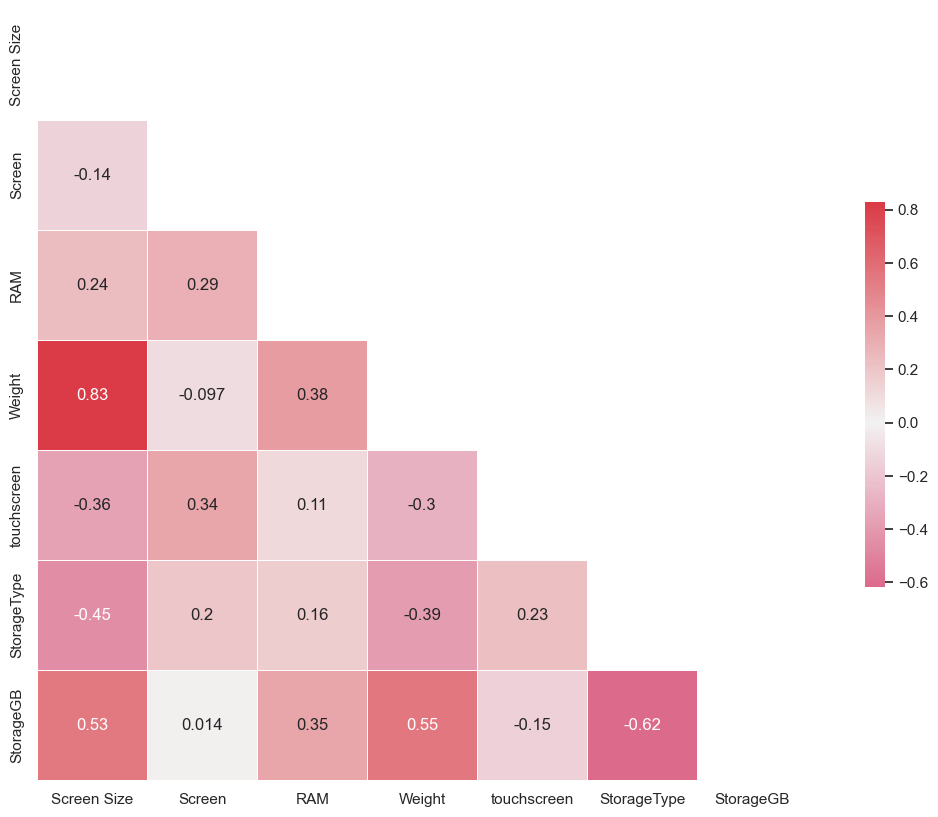

In [96]:
#plot_correlation_heatmap(data) #no vemos corr por encima de 90 o -90 por lo tanto descartamos colinealidad en los datos. Está un poco raro cuanto afecta el tamaño de pantalla al peso
#supongo conforme la pantalla es mas grande, el ordenador en si tambien. Esta metrica es nuestra unica medida de 'dimensiones' del ordenador

numeric_columns = data.select_dtypes(include=np.number)

plt.figure(figsize=(15, 10))
sns.set(style='white')

mask = np.triu(np.ones_like(numeric_columns.corr(), dtype=bool))
cmap = sns.diverging_palette(0, 10, as_cmap=True)

sns.heatmap(numeric_columns.corr(),
            mask=mask,
            cmap=cmap,
            center=0,
            square=True,
            annot=True,
            linewidths=0.5,
            cbar_kws={'shrink': 0.5})

plt.show();

In [97]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Manufacturer      1302 non-null   object 
 1   Category          1302 non-null   object 
 2   Screen Size       1302 non-null   float64
 3   Screen            1302 non-null   int32  
 4   CPU               1302 non-null   object 
 5   RAM               1302 non-null   int32  
 6   GPU               1302 non-null   object 
 7   Operating System  1302 non-null   object 
 8   Weight            1302 non-null   float64
 9   touchscreen       1302 non-null   int32  
 10  processor brand   1301 non-null   object 
 11  StorageType       1302 non-null   int32  
 12  StorageGB         1302 non-null   int32  
dtypes: float64(2), int32(5), object(6)
memory usage: 106.9+ KB


In [98]:
columns_to_encode = ['Manufacturer', 'Category', 'CPU', 'GPU', 'Operating System', 'processor brand', 'StorageType']
encoded_data = pd.get_dummies(data, columns=columns_to_encode)

In [99]:
encoded_data.shape

(1302, 64)

Separamos data en entrenamiento y test, devolvemos a entrenamiento su columna de precios

In [100]:
train_clean = encoded_data.iloc[:977, :]
test_clean = encoded_data.iloc[977:, :]
train_clean.shape, test_clean.shape

((977, 64), (325, 64))

In [101]:
train_clean['Price']= precios

## ML

Empezamos con un lazy regressor para ver que modelos funcionan mejor

In [102]:
X= train_clean.drop('Price', axis=1)
y= train_clean['Price']

In [103]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=42)


In [104]:
lazy=LazyRegressor()

In [105]:
lazy.fit(X_train, X_test, y_train, y_test)

100%|██████████| 42/42 [00:24<00:00,  1.73it/s]


(                               Adjusted R-Squared  R-Squared         RMSE   
 Model                                                                       
 ExtraTreesRegressor                          0.56       0.70   3267730.33  \
 KNeighborsRegressor                          0.53       0.69   3367350.19   
 RandomForestRegressor                        0.53       0.68   3383667.30   
 BaggingRegressor                             0.51       0.67   3464260.27   
 ExtraTreeRegressor                           0.50       0.67   3476593.77   
 DecisionTreeRegressor                        0.49       0.65   3535676.68   
 LGBMRegressor                                0.47       0.65   3575440.34   
 HistGradientBoostingRegressor                0.47       0.64   3590994.97   
 GradientBoostingRegressor                    0.34       0.56   3999730.98   
 LarsCV                                       0.31       0.54   4089357.95   
 LassoLarsCV                                  0.31       0.54   

In [106]:
ETR=ExtraTreesRegressor()

In [107]:
ETR.fit(X,y)

ExtraTreesRegressor()

In [108]:
pred=ETR.predict(test_clean)

In [109]:
muestra['Price']=pred

In [110]:
muestra.to_csv('../DATA/muestra(ETR).csv', index=False)

In [111]:
KNR= KNeighborsRegressor ()

In [112]:
KNR.fit(X,y)

KNeighborsRegressor()

In [113]:
pred2=KNR.predict(test_clean)

In [114]:
muestra['Price']=pred2

In [115]:
muestra.to_csv('../DATA/muestra(KNR).csv', index=False) #Este da peor score que el primero en el leaderboard pero bueno no dice si está mejor el 100% si no el 40% disponible 

Probamos con H20

In [116]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 20.0.1+9-29, mixed mode, sharing)
  Starting server from C:\Users\anton\AppData\Local\Programs\Python\Python311\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\anton\AppData\Local\Temp\tmpv7ujglqk
  JVM stdout: C:\Users\anton\AppData\Local\Temp\tmpv7ujglqk\h2o_anton_started_from_python.out
  JVM stderr: C:\Users\anton\AppData\Local\Temp\tmpv7ujglqk\h2o_anton_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Paris
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,1 month
H2O_cluster_name:,H2O_from_python_anton_8q4nbx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.840 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [117]:
h2o_df = h2o.H2OFrame(train_clean)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [118]:
x = h2o_df.columns  # Use all columns as predictors
y = 'Price'  # Target variable
x.remove(y)  # Remove target variable from predictors


In [119]:
train, valid = h2o_df.split_frame(ratios=[0.8], seed=42)

In [120]:
aml = H2OAutoML(max_models=10, seed=42)  # Set the maximum number of models to train
aml.train(x=x, y=y, training_frame=train, validation_frame=valid)


AutoML progress: |
19:45:50.690: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
19:45:50.712: AutoML: XGBoost is not available; skipping it.
19:45:50.826: _train param, Dropping bad and constant columns: [CPU_Cortex, GPU_ARM]


19:45:52.109: _train param, Dropping bad and constant columns: [CPU_Cortex, GPU_ARM]

██
19:45:53.904: _train param, Dropping bad and constant columns: [CPU_Cortex, GPU_ARM]

████
19:45:56.385: _train param, Dropping bad and constant columns: [CPU_Cortex, GPU_ARM]
19:45:57.337: _train param, Dropping bad and constant columns: [CPU_Cortex, GPU_ARM]
19:45:58.212: _train param, Dropping bad and constant columns: [CPU_Cortex, GPU_ARM]

██
19:45:59.110: _train param, Dropping bad and constant columns: [CPU_Cortex, GPU_ARM]

██
19:46:01.301: _train param, Dropp

key,value
Stacking strategy,cross_validation
Number of base models (used / total),4/5
# GBM base models (used / total),1/1
# DRF base models (used / total),2/2
# DeepLearning base models (used / total),1/1
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [121]:
leaderboard = aml.leaderboard
print(leaderboard)


model_id                                                        rmse          mse          mae     rmsle    mean_residual_deviance
StackedEnsemble_BestOfFamily_1_AutoML_1_20230528_194550  2.79507e+06  7.8124e+12   1.72453e+06  0.22156                7.8124e+12
GBM_grid_1_AutoML_1_20230528_194550_model_1              2.82112e+06  7.95872e+12  1.7243e+06   0.223877               7.95872e+12
StackedEnsemble_AllModels_1_AutoML_1_20230528_194550     2.83582e+06  8.04187e+12  1.72442e+06  0.222064               8.04187e+12
GBM_5_AutoML_1_20230528_194550                           2.9088e+06   8.46112e+12  1.71862e+06  0.221236               8.46112e+12
GBM_2_AutoML_1_20230528_194550                           2.92035e+06  8.52844e+12  1.79336e+06  0.231181               8.52844e+12
GBM_3_AutoML_1_20230528_194550                           2.93588e+06  8.61942e+12  1.82193e+06  0.231026               8.61942e+12
DRF_1_AutoML_1_20230528_194550                           2.95608e+06  8.73841e+12  1

In [122]:
h2test=h2o.H2OFrame(test_clean)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [123]:
y_pred=aml.leader.predict(h2test)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [130]:
y_pred.head()

predict
6.89717e+06
1.52606e+07
1.28979e+07
9.83062e+06
4.61756e+06
6.10544e+06
7.20068e+06
5.78427e+06
6.47411e+06
1.0618e+07


In [134]:
pred3= h2o.as_list(y_pred)

In [135]:
muestra['Price'] = pred3

In [137]:
muestra.to_csv('../DATA/muestra(H2o).csv', index=False)